The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


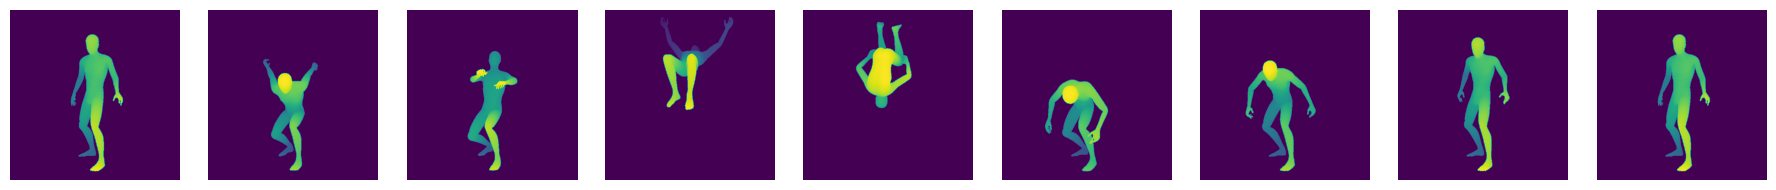

In [20]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.backprojection import project_visible_verts_to_cameras
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map

torch.set_grad_enabled(False)

animation_tag = "backflip:latest"

animation = AnimationArtifact.from_wandb_artifact_tag(animation_tag)
n_frames = 9
frame_indices = animation.frame_indices(n_frames)
cameras, meshes = animation.load_frames(frame_indices)

# precompute backprojection
visible_vert_coords, visible_vert_indices = project_visible_verts_to_cameras(
    meshes, cameras
)

depths = render_depth_map(meshes, cameras)
display_ims(depths)

## Initialize test Spatial Features

Create `spatial_features_dict` and `spatial_features`. These are RGB images, in the actual code they will be high-dimensional feature maps.

Also create functions for easily visualizing them

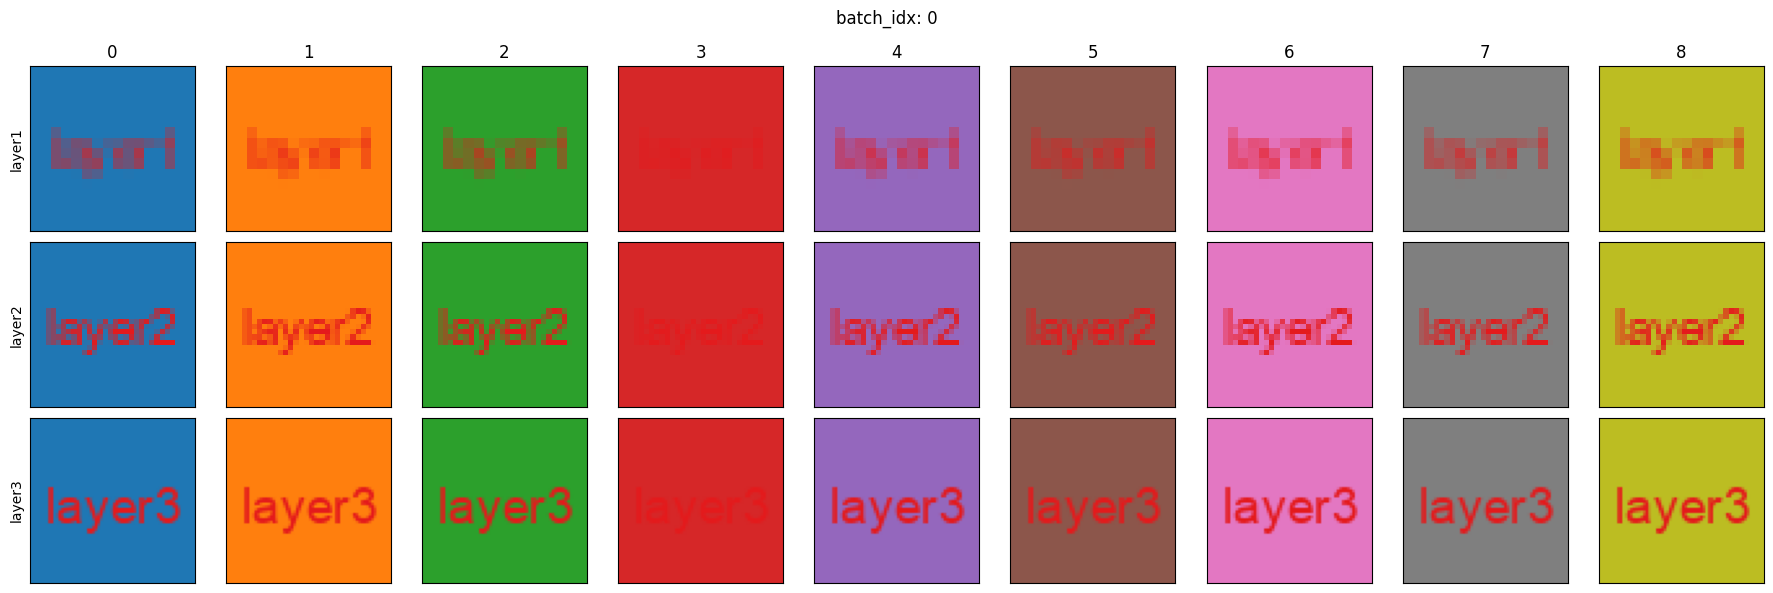

In [6]:
from matplotlib.cm import get_cmap
from text3d2video.utilities.ipython_utils import display_ims_grid
import torchvision.transforms.functional as TF

from visual_tests.testing_utils import test_img

def make_test_diffusion_spatial_features(
    layers: list,
    resolutions: list,
    n_frames: int,
    n_batches: int,
    device="cuda",
    cmap_frame="tab10",
    cmap_batch="Set1",
):
    cmap_frame = get_cmap(cmap_frame)
    cmap_batch = get_cmap(cmap_batch)

    frame_indices = torch.arange(n_frames)
    frame_colors = cmap_frame(frame_indices)
    batch_colors = cmap_batch(torch.arange(n_batches))

    features = {}

    for layer, resolution in zip(layers, resolutions):
        all_ims = []
        for batch in range(n_batches):
            images = [
                test_img(
                    resolution=resolution,
                    color=frame_colors[i][0:3],
                    txt=layer,
                    textcolor=batch_colors[batch][0:3],
                )
                for i in range(n_frames)
            ]
            images = torch.stack([TF.to_tensor(img) for img in images]).to(device)
            all_ims.append(images)

        layer_features = torch.stack(all_ims)

        features[layer] = layer_features

    return features


layers = ["layer1", "layer2", "layer3"]
resolutions = [16, 32, 64]

layer_resolutions = dict(zip(layers, resolutions))

def display_spatial_features_dict(features, batch_idx=0, scale=2):
    ims_grid = []
    n_frames = None

    for layer, resolution in zip(layers, resolutions):
        ims = features[layer]
        ims = ims[batch_idx]
        n_frames = ims.shape[0]
        ims = [TF.to_pil_image(im) for im in ims]
        ims_grid.append(ims)

    display_ims_grid(
        ims_grid,
        col_titles=[int(i) for i in torch.arange(n_frames)],
        row_titles=layers,
        scale=scale,
        title=f"batch_idx: {batch_idx}",
    )

spatial_features_dict = make_test_diffusion_spatial_features(
    layers, resolutions, n_frames, 2
)

display_spatial_features_dict(spatial_features_dict, batch_idx=0)

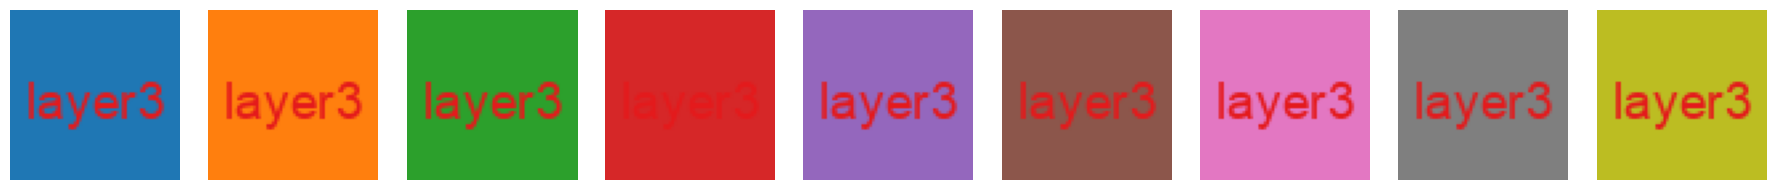

In [7]:
module = list(spatial_features_dict.keys())[-1]
batch_idx = 0

spatial_features = spatial_features_dict[module][batch_idx]
resolution = 64

def display_spatial_features(feature_maps, scale=2):
    feature_maps_pil = [TF.to_pil_image(im.cpu()) for im in feature_maps]
    display_ims(feature_maps_pil, scale=scale)

display_spatial_features(spatial_features)

## Test aggregation and rendering

These functions perform aggregation/rendering of the spatial features, later we will extend them to operate on a dictoinary of features for ease of use in the pipelines

In [21]:
from text3d2video.backprojection import (
    aggregate_spatial_features,
)
from text3d2video.rendering import make_rasterizer


vert_ft = aggregate_spatial_features(
    spatial_features,
    meshes.num_verts_per_mesh()[0],
    visible_vert_coords,
    visible_vert_indices,
)

vert_ft.shape

torch.Size([14442, 3])

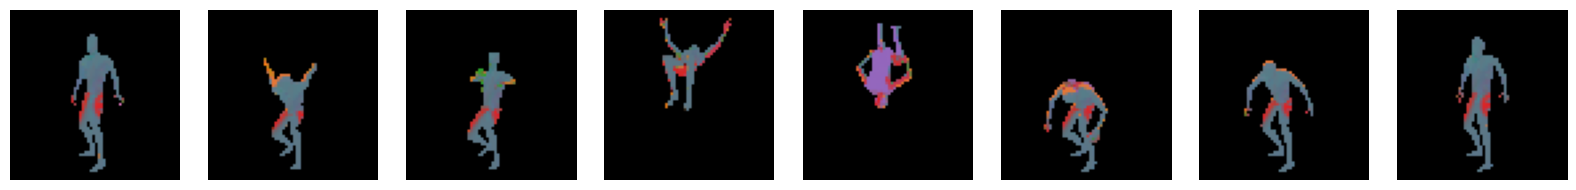

In [36]:
from torch import Tensor

from text3d2video.backprojection import rasterize_and_render_vt_features

raster_res = 100
render_res = 64

indices = Tensor([0, 1, 2]).long()
indices = [0, 1, 2, 3, 4, 5, 6, 7]

# rasterize all meshes
rasterizer = make_rasterizer(resolution=raster_res)
fragments = rasterizer(meshes, cameras=cameras)

meshes_chunk = meshes[indices]
cams_chunk = cameras[indices]

renders = rasterize_and_render_vt_features(
    vert_ft, meshes_chunk, cams_chunk, resolution=render_res
)

display_spatial_features(renders)

## Test aggr/rendering for Dict

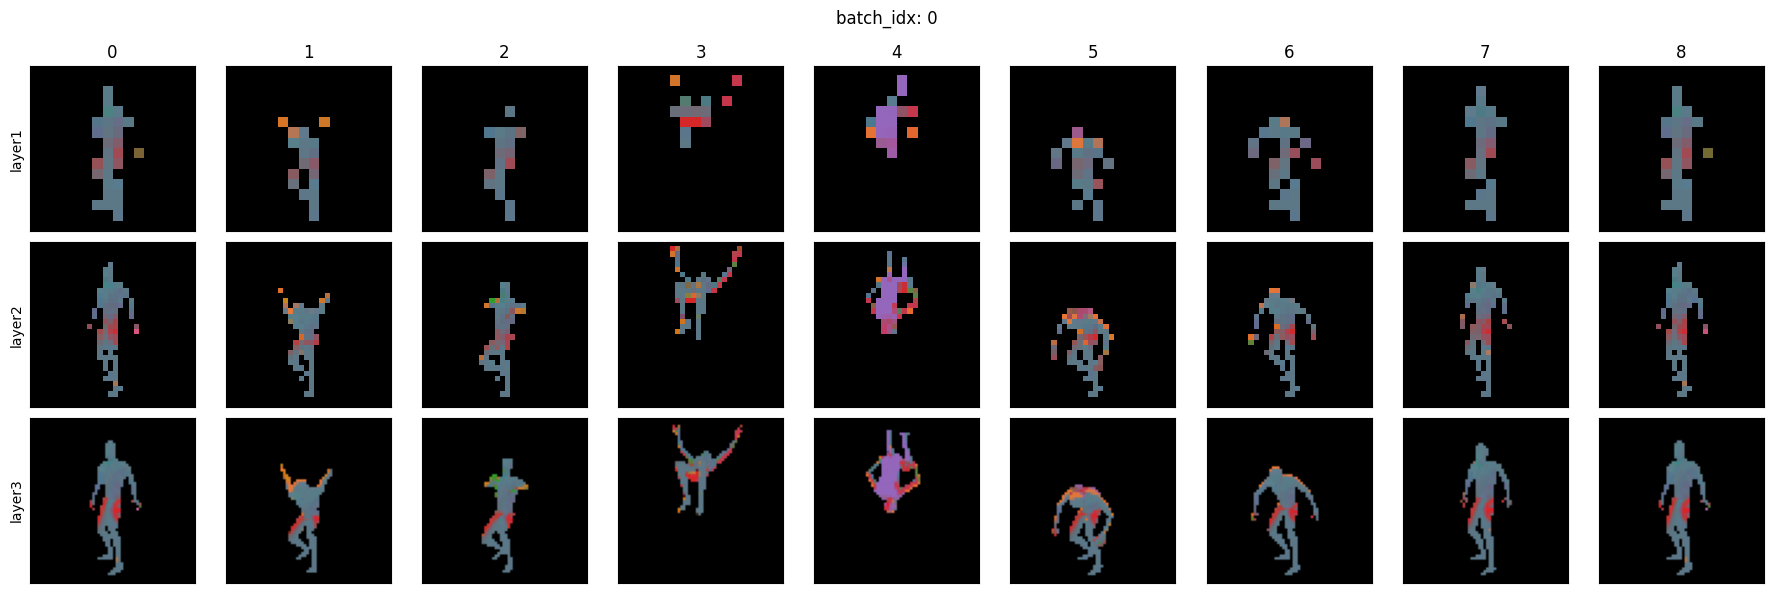

In [31]:
from text3d2video.backprojection import (
    aggregate_spatial_features_dict,
    rasterize_and_render_vert_features_dict,
)

vert_fts = aggregate_spatial_features_dict(
    spatial_features_dict,
    meshes.num_verts_per_mesh()[0],
    visible_vert_coords,
    visible_vert_indices,
)

layer_resolutions = {
    layer: feature.shape[-1] for layer, feature in spatial_features_dict.items()
}

renders = rasterize_and_render_vert_features_dict(
    vert_fts,
    meshes,
    cameras,
    resolutions=layer_resolutions,
)

display_spatial_features_dict(renders, batch_idx=0, scale=2)